### Import Packages

In [1]:
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime

import os
import sys

import imageio

%config InlineBackend.figure_format = 'retina'

### Set the DuckDB and Import the Data

In [2]:
con = duckdb.connect(database=":memory:")
con.execute(
    "CREATE VIEW 'gas_prices' AS SELECT * FROM 'C:/Users/alezi/OneDrive/Escritorio/Geospatial Data/final_proyect/data_in/spanish_gas_prices.parquet';"
)

In [3]:
# Execute a query to retrieve all the dataset rows where province_name is 'MADRID' (3 minutes aprox)
result = con.execute("SELECT * FROM gas_prices WHERE province_name = 'MADRID';")

# Fetch all the rows from the result
rows = result.fetchall()

# Create a pandas DataFrame from the query result
madrid_raw = pd.DataFrame(rows, columns=result.description)
madrid_raw.head()

,"(station_id, NUMBER, None, None, None, None, None)","(date, Date, None, None, None, None, None)","(gasoline_95E5, NUMBER, None, None, None, None, None)","(gasoline_95E5_premium, NUMBER, None, None, None, None, None)","(gasoline_95E10, NUMBER, None, None, None, None, None)","(gasoline_98E5, NUMBER, None, None, None, None, None)","(gasoline_98E10, NUMBER, None, None, None, None, None)","(diesel_A, NUMBER, None, None, None, None, None)","(diesel_B, NUMBER, None, None, None, None, None)","(diesel_premium, NUMBER, None, None, None, None, None)",...,"(road_side, STRING, None, None, None, None, None)","(restriction, STRING, None, None, None, None, None)","(sender, STRING, None, None, None, None, None)","(schedule, STRING, None, None, None, None, None)","(region_id, NUMBER, None, None, None, None, None)","(region_name, STRING, None, None, None, None, None)","(province_id, NUMBER, None, None, None, None, None)","(province_name, STRING, None, None, None, None, None)","(municipality_id, NUMBER, None, None, None, None, None)","(municipality_name, STRING, None, None, None, None, None)"
0,14661,2023-07-29,1.569000000,None,None,None,None,1.369000000,None,None,...,D,P,dm,L-D: 24H,13,Madrid,28,MADRID,4418,Torrejón de Ardoz
1,14740,2023-07-29,1.569000000,None,None,None,None,1.419000000,None,1.429000000,...,N,P,dm,L-D: 24H,13,Madrid,28,MADRID,4328,Daganzo de Arriba
2,3075,2023-07-29,1.709000000,None,None,1.854000000,None,1.559000000,None,1.609000000,...,N,P,OM,L-D: 24H,13,Madrid,28,MADRID,4432,Valdemoro
3,3148,2023-07-29,1.709000000,None,None,None,None,1.579000000,1.329000000,1.659000000,...,I,P,dm,L-V: 07:00-23:00; S: 08:00-22:00; D: 09:00-22:00,13,Madrid,28,MADRID,4420,Torrejón de Velasco
4,13525,2023-07-29,1.589000000,None,None,None,None,1.399000000,None,None,...,N,P,dm,L-S: 06:00-00:00; D: 08:00-00:00,13,Madrid,28,MADRID,4317,Ciempozuelos


### Data Managment

In [4]:
# Set correctly and format the columns names
data = madrid_raw.copy()

# Extract the first element of each multi-level column index
new_columns = [col[0] for col in madrid_raw.columns]

# Set the DataFrame columns to the new list of names
data.columns = new_columns

In [5]:
# Set the date as a datetime object
data["date"] = pd.to_datetime(data["date"])
# Create a year column and a month column
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month

### Descriptive Statistics

In [ ]:
# Print the different columns names and count the amount of missing values in each one
print(data.isnull().sum())
# Count the amount of different station_ids are in each year and then by month
data.groupby("year")["station_id"].nunique()
data.groupby("month")["station_id"].nunique()

In [15]:
# Print the top 10 stations with the most amount of values over the time periods
data.groupby("station_id")["gasoline_95E5"].count().sort_values(ascending=False).head(10)

station_id
520     6040
4539    6040
4576    6040
3157    6040
4555    6040
3161    6040
4546    6040
4540    6040
3164    6040
4534    6040
Name: gasoline_95E5, dtype: int64

In [ ]:
stations = data.groupby("station_id")["year"].nunique()

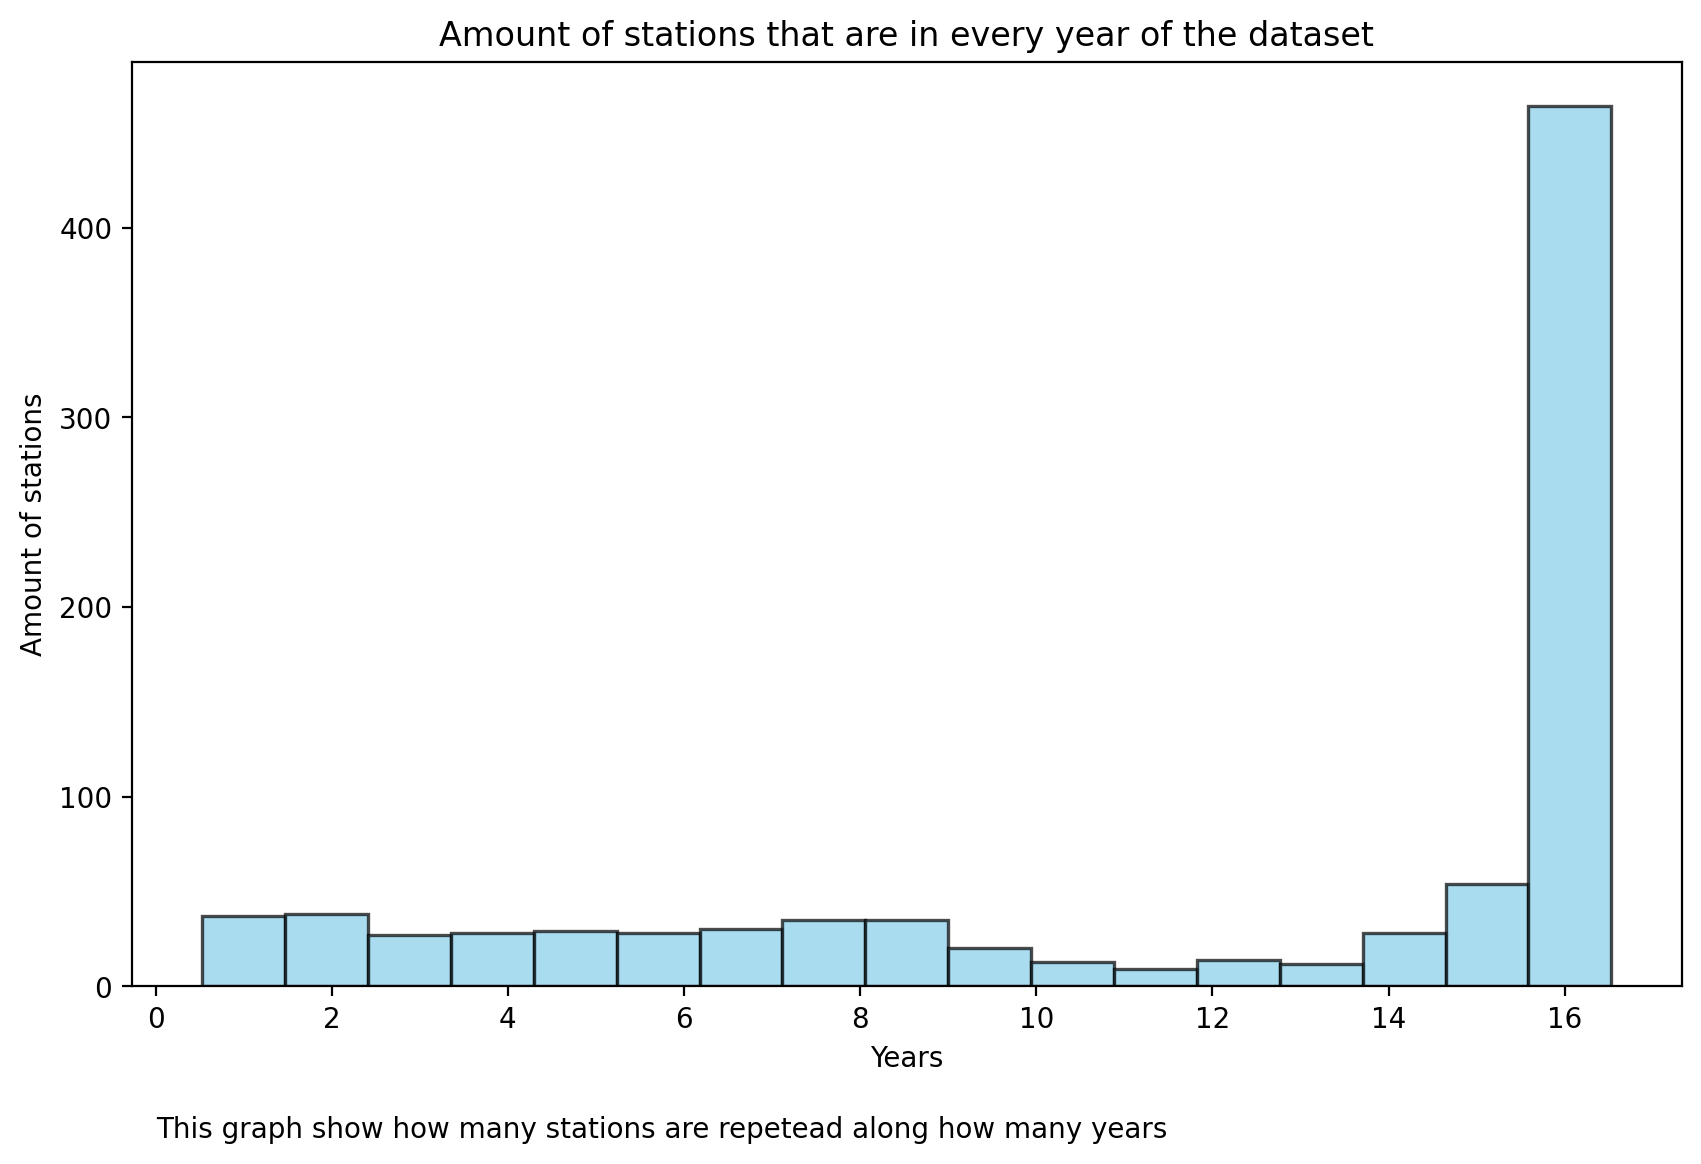

In [24]:
# Plot the amount of stations that are in every year of the dataset
plt.figure(figsize=(10, 6))
stations.plot(kind="hist", bins=17, color="skyblue", edgecolor="black", linewidth=1.2, alpha=0.7, align="left")
plt.title("Amount of stations that are in every year of the dataset")
plt.xlabel("Years")
plt.ylabel("Amount of stations")
# add a note to the plot
plt.text(0, -80, "This graph show how many stations are repetead along how many years", fontsize=10, color="black")
plt.show()

In [12]:
# Verify which station_ids are in every year of the dataset
print('The amount of stations that are in every year of the dataset is:', len(stations[stations == 17]))
print('The total amount of stations that are in the dataset is:', data.station_id.nunique())


The amount of stations that are in every year of the dataset is: 464
The total amount of stations that are in the dataset is: 901


### Set the Geodataframe

In [100]:
# Keep only the observation of the first day of each month
final_data = data[data["date"].dt.day == 1]

In [106]:
# First keep the columns that are going to be used
cols = ["station_id" ,"date" , "gasoline_95E5", "diesel_A", "name", "address", "town", "zip_code", "longitude","latitude",
        "road_side", "restriction", "sender", "schedule", "region_id", "region_name", "province_id", "province_name",
        "municipality_id", "municipality_name", "year", "month"]
# Create a new DataFrame with the selected columns
final_data = final_data[cols]

In [74]:
# Set the geodataframe with the latitude and longitude columns as the geometry
gdf = gpd.GeoDataFrame(
    final_data, geometry=gpd.points_from_xy(final_data.longitude, final_data.latitude)
)
# Set the crs to the geodataframe
gdf = gdf.set_crs(epsg=4326)

# Import the map of Madrid
madrid = gpd.read_file(r"C:\Users\alezi\OneDrive\Escritorio\Geospatial Data\final_proyect\data_in\ne_10m_admin_1_states_provinces\ne_10m_admin_1_states_provinces.shp")
madrid = madrid[madrid['name'] == 'Madrid']
madrid = madrid.to_crs(epsg=4326)


In [ ]:
# Export the geodataframe to a shapefile
# I change the format of the date column to a string to avoid problems with the export
# gdf["date"] = gdf["date"].dt.strftime("%Y-%m-%d")
# Format the in64 to float
# gdf["station_id"] = gdf["station_id"].astype(float)
# gdf["year"] = gdf["year"].astype(float)
# gdf["month"] = gdf["month"].astype(float)
# gdf["region_id"] = gdf["region_id"].astype(float)
# gdf["province_id"] = gdf["province_id"].astype(float)
# gdf["municipality_id"] = gdf["municipality_id"].astype(float)

# gdf.to_file(r"C:\Users\alezi\OneDrive\Escritorio\Geospatial Data\final_proyect\data_in\gas_stations_madrid.shp")

In [99]:
# Export only the station_id, date, geometry columns to a shp
gdf[["station_id", "date", "geometry"]].to_file(r"C:\Users\alezi\OneDrive\Escritorio\Geospatial Data\final_proyect\data_in\geomtries.shp")

In [94]:
# Export the geodataframe to a parquet file
gdf.to_parquet(r"C:\Users\alezi\OneDrive\Escritorio\Geospatial Data\final_proyect\data_in\gas_stations_madrid.parquet")

### GIF
We are going to build a .gif with the gas stations in Madrid over the years 

In [139]:
# First plot each map of the gas stations in Madrid for each year and save it as a .png in a folder
# Set the style
plt.style.use('seaborn-v0_8-darkgrid')

for year in gdf["year"].unique().astype(int):
    
    # Fig
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot Madrid boundary
    madrid.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.7)
    gdf[gdf["year"] == year].plot(ax=ax, color="blue", markersize=10, alpha=0.7)
    
    # Set title
    ax.set_title(f"Gas stations in Madrid in {year}", fontsize=20, fontweight='bold', fontfamily='serif'), ax.title.set_position([.5, 1.05])
    # Don't show x and y axis
    ax.set_axis_off()
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"C:/Users/alezi/OneDrive/Escritorio/Geospatial Data/final_proyect/gif_figures/gas_stations_madrid_{year}.png")
    plt.close()



In [147]:
# Adjust the directory path
directory = 'C:/Users/alezi/OneDrive/Escritorio/Geospatial Data/final_proyect/gif_figures'

# Get a list of image files in the directory
filenames = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

# Create the animation (.gif)
with imageio.get_writer('Gas_Station_Over_Years.gif', fps=5, loop = 100) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved!\n')


C:\Users\alezi\AppData\Local\Temp\ipykernel_18208\1171438929.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Gif saved!



### Graphs

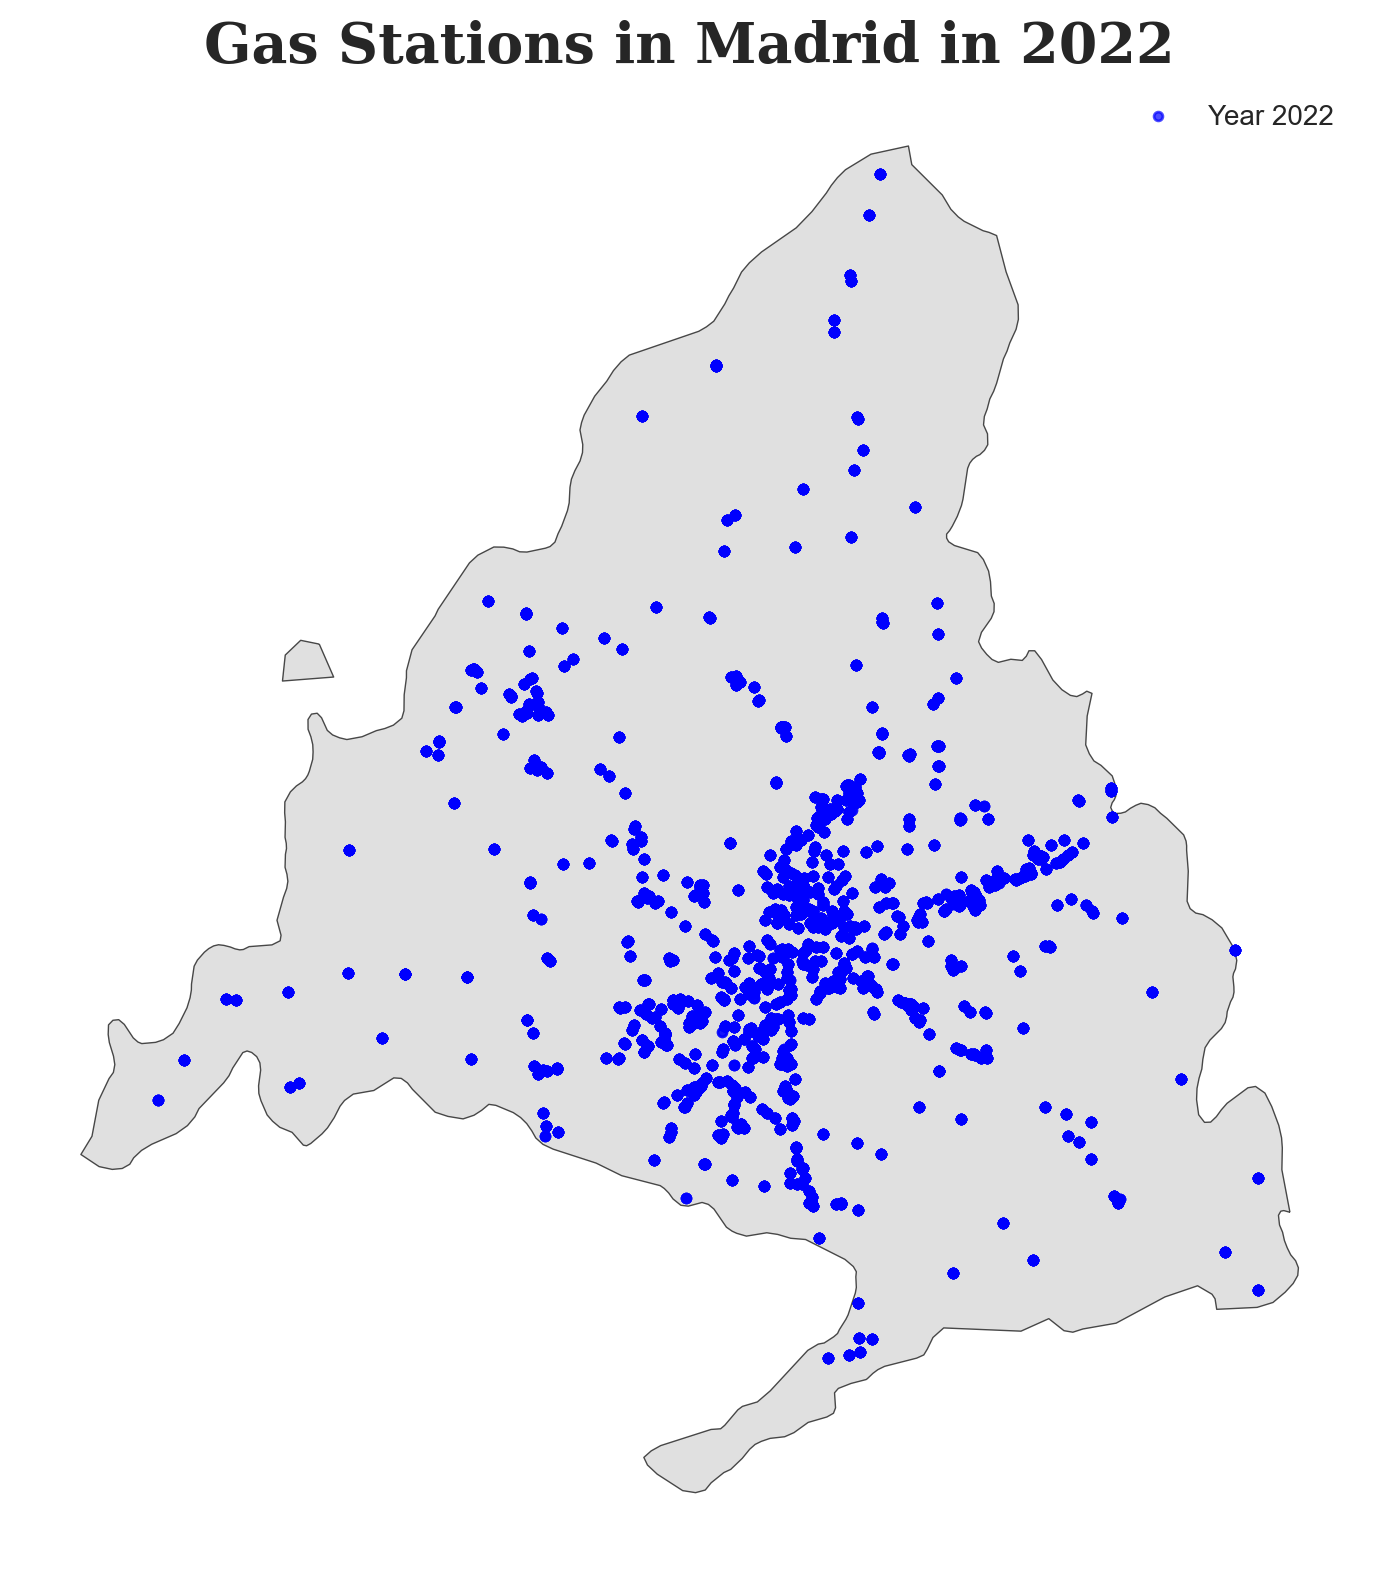

In [133]:

# Set the style
plt.style.use('seaborn-v0_8-darkgrid')

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(14, 8))

# Plot Madrid boundary
madrid.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.7)

# Plot data for the year 2022
gdf[gdf["year"] == 2022].plot(ax=ax, color="blue", markersize=10, alpha=0.7)

# Set title
ax.set_title("Gas Stations in Madrid in 2022", fontsize=20, fontweight='bold', fontfamily='serif'), ax.title.set_position([.5, 1.05])

# Don't show x and y axis
ax.set_axis_off()
# Add legend
ax.legend()

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


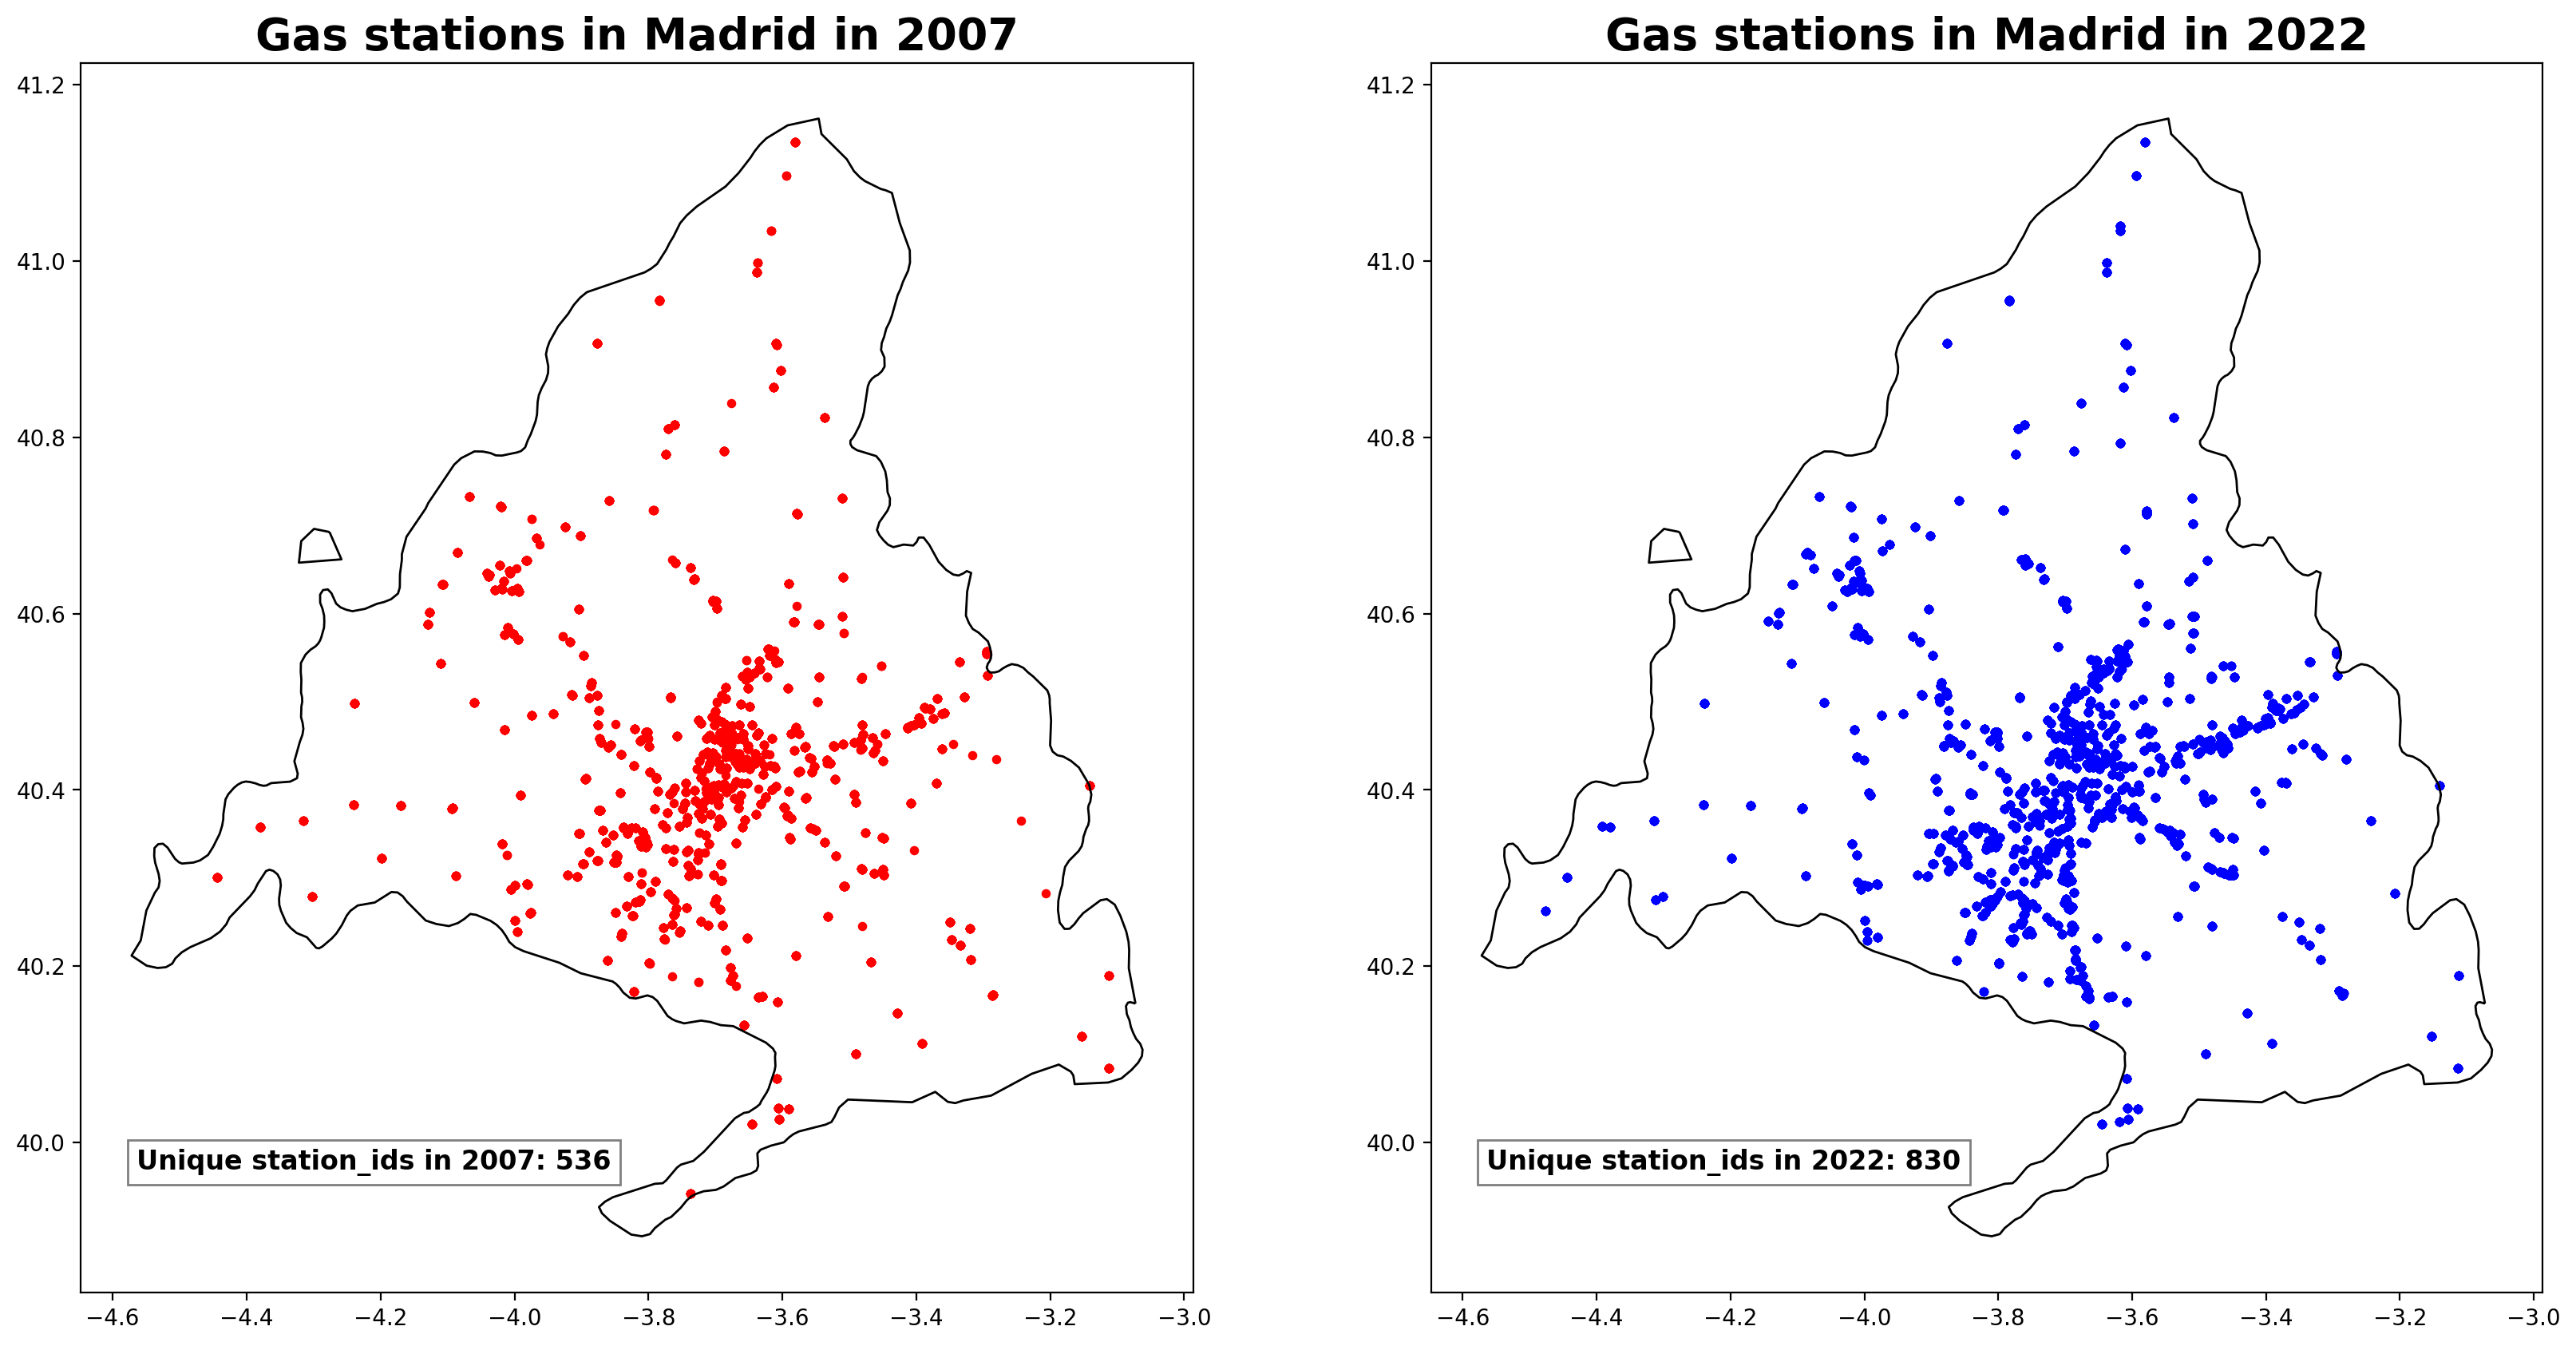

In [71]:
# Make a plot of the gas stations in Madrid in the year 2007 and in 2022. 
# The map of madrid is going to be used as a background
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
madrid.boundary.plot(ax=ax[0], linewidth=1, color="black")
madrid.boundary.plot(ax=ax[1], linewidth=1, color="black")
gdf[gdf["year"] == 2007].plot(ax=ax[0], color="red", markersize=10, label="2007")
gdf[gdf["year"] == 2022].plot(ax=ax[1], color="blue", markersize=10, label="2022")
ax[0].set_title("Gas stations in Madrid in 2007", fontsize=20, fontweight="bold" )
ax[1].set_title("Gas stations in Madrid in 2022", fontsize=20, fontweight="bold")
# Add as a note the amount of gas stations in each year 
count_2007 = gdf[gdf["year"] == 2007].station_id.nunique()
ax[0].text(0.05, 0.1, f"Unique station_ids in 2007: {count_2007}", transform=ax[0].transAxes, fontsize=12, color="black", fontweight="bold", bbox=dict(facecolor='white', alpha=0.5))

count_2022 = gdf[gdf["year"] == 2022].station_id.nunique()
ax[1].text(0.05, 0.1, f"Unique station_ids in 2022: {count_2022}", transform=ax[1].transAxes, fontsize=12, color="black", fontweight="bold", bbox=dict(facecolor='white', alpha=0.5))





plt.show()
